#**Data Processer**

In [ ]:
import pandas as pd
import cv2
import requests
import numpy as np
from io import BytesIO
from PIL import Image

# Read the original CSV file into a pandas DataFrame
df = pd.read_csv('All_Tweets_Featurized.csv')

# Function to filter images not containing "svg" or "profile" in their names
def filter_images(images):
    if pd.notna(images):
        return [image for image in str(images).split(', ') if 'svg' not in image and 'profile' not in image]
    else:
        return []

# Apply the filter_images function to the Images column
df['Images'] = df['Images'].apply(filter_images)

# Explode the DataFrame to separate rows for each image
df = df.explode('Images')

# Function to compute colorfulness score for an image using OpenCV
def calculate_colorfulness(row):
    try:
        image_url = row['Images']

        if pd.isna(image_url):
            return None  # Return None for NaN values

        # Check if the URL is valid
        if not image_url.startswith(('http://', 'https://')):
            print(f"Invalid URL at line {row.name + 2}: {image_url}")
            return None

        # Download the image from the internet
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an error for unsuccessful HTTP responses

        img = Image.open(BytesIO(response.content))

        # Convert the image to the LAB color space
        lab_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2LAB)

        # Calculate the saturation channel (b*) standard deviation
        colorfulness_score = np.std(lab_img[:, :, 2])

        return colorfulness_score
    except Exception as e:
        print(f"Error calculating colorfulness at line {row.name + 2}: {e}")
        return None

# Apply the calculate_colorfulness function to the DataFrame
df['Colorfulness'] = df.apply(calculate_colorfulness, axis=1)

# Exclude rows where 'Image Type' is 0 or 1 but 'Colorfulness' is NaN
df = df[~((df['Image Type'].isin([0, 1])) & pd.isna(df['Colorfulness']))]

# Further processing based on conditions
df['Colorfulness'] = df['Colorfulness'].fillna(-1)

# Save the updated DataFrame to a new CSV file
df.to_csv('All_Tweets_Transformed.csv', index=False)


Error calculating colorfulness at line 7: 404 Client Error: Not Found for url: https://pbs.twimg.com/media/F210kneW4AA8CjK?format=jpg&name=900x900%20
Invalid URL at line 24:  https://pbs.twimg.com/media/FwKZupUacAAU3Jw?format=jpg&name=small
Error calculating colorfulness at line 36: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1

Error calculating colorfulness at line 36: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_he

<ipython-input-5-2b51f7108c26>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Colorfulness'] = df['Colorfulness'].fillna(-1)


# **Statistical Tests**

In [ ]:
from itertools import combinations
from scipy.stats import f_oneway

# Read the transformed CSV file into a pandas DataFrame
df = pd.read_csv('All_Tweets_Transformed.csv')

# Convert categorical columns to the correct data type
categorical_columns = ['Image Type', 'Text Sentiment', 'Topic', 'Quality of Image', 'Relevant Image', 'Face Presence']
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert numerical columns to the correct data type
numerical_columns = ['Word Count', 'Number of Hashtags', 'Colorfulness', 'Engagement Score']
df[numerical_columns] = df[numerical_columns].astype(float)

# Convert 'Timestamp' to a datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract year, month, and hour as categorical variables
df['Year'] = df['Timestamp'].dt.year.astype('category')
df['Month'] = df['Timestamp'].dt.month.astype('category')
df['Hour'] = df['Timestamp'].dt.hour.astype('category')

# Specify the numerical variable
numerical_var = 'Engagement Score'

# Get a list of all categorical columns including 'Timestamp'
all_categorical_columns = categorical_columns + ['Year', 'Month', 'Hour']

# Create an empty DataFrame to store ANOVA results
anova_results = pd.DataFrame(columns=['Categorical Variables', 'F-statistic', 'p-value', 'Statistical Significance'])

# Perform ANOVA tests for all combinations of categorical variables
for i in range(1, len(all_categorical_columns) + 1):
    for combo in combinations(all_categorical_columns, i):
        categorical_vars = list(combo)

        # Filter out rows with NaN values in the numerical variable
        df_anova = df.dropna(subset=[numerical_var])

        # Perform ANOVA test
        groups = [group[1][numerical_var].values for group in df_anova.groupby(categorical_vars)]
        f_statistic, p_value = f_oneway(*groups)

        # Check for statistical significance
        alpha = 0.05
        significance = 'Yes' if p_value < alpha else 'No'

        # Append the results to the DataFrame
        result_row = pd.Series({'Categorical Variables': categorical_vars,
                                'F-statistic': f_statistic,
                                'p-value': p_value,
                                'Statistical Significance': significance})
        anova_results = anova_results.append(result_row, ignore_index=True)

# Save the DataFrame to a CSV file
anova_results.to_csv('ANOVA_Results.csv', index=False)

# Display the DataFrame
print(anova_results)


<ipython-input-11-33bfff08e08c>:41: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  groups = [group[1][numerical_var].values for group in df_anova.groupby(categorical_vars)]
<ipython-input-11-33bfff08e08c>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append(result_row, ignore_index=True)
<ipython-input-11-33bfff08e08c>:41: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  groups = [group[1][numerical_var].values for group in df_anova.groupby(categorical_vars)]
<ipython-input-11-33bfff08e08c>:53: FutureWarning: The frame.append

                                 Categorical Variables  F-statistic  \
0                                         [Image Type]     4.654395   
1                                     [Text Sentiment]     5.610478   
2                                              [Topic]     3.394971   
3                                   [Quality of Image]     6.215662   
4                                     [Relevant Image]     3.381841   
..                                                 ...          ...   
506  [Image Type, Text Sentiment, Topic, Relevant I...     7.095692   
507  [Image Type, Text Sentiment, Quality of Image,...     2.885138   
508  [Image Type, Topic, Quality of Image, Relevant...     6.705348   
509  [Text Sentiment, Topic, Quality of Image, Rele...     7.436684   
510  [Image Type, Text Sentiment, Topic, Quality of...     7.356873   

          p-value Statistical Significance  
0    9.712511e-03                      Yes  
1    3.767394e-03                      Yes  
2    3.22423

<ipython-input-11-33bfff08e08c>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append(result_row, ignore_index=True)


# **Machine Learning Models**
#### *Linear Regression, Random Forest, and SVM*

### **Model 1**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace 'All_Tweets_Transformed-Final.csv' with your actual file path)
df = pd.read_csv('All_Tweets_Transformed-Final.csv')

# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Topic', 'Text Sentiment', 'Word Count', 'Number of Hashtags', 'Quality of Image', 'Relevant Image', 'Face Presence', 'Colorfulness']
target = 'Engagement Score'

# Use LabelEncoder for the 'Topic' variable
label_encoder = LabelEncoder()
df_regression['Topic'] = label_encoder.fit_transform(df_regression['Topic'])

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
regressor_lr = LinearRegression()
regressor_lr.fit(X_train, y_train)
y_pred_lr = regressor_lr.predict(X_test)

# Random Forest Model
regressor_rf = RandomForestRegressor()
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)

# SVM Model
regressor_svm = SVR()
regressor_svm.fit(X_train, y_train)
y_pred_svm = regressor_svm.predict(X_test)

# Evaluate the models
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression R-squared: {r2_rf}")

mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
print(f"SVM Regression R-squared: {r2_svm}")

# Cross-validation
cv_scores_lr = cross_val_score(regressor_lr, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_lr = -cv_scores_lr.mean()
print(f"Cross-validated Linear Regression Mean Squared Error: {cv_mse_lr}")

cv_scores_rf = cross_val_score(regressor_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_rf = -cv_scores_rf.mean()
print(f"Cross-validated Random Forest Regression Mean Squared Error: {cv_mse_rf}")

cv_scores_svm = cross_val_score(regressor_svm, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_svm = -cv_scores_svm.mean()
print(f"Cross-validated SVM Regression Mean Squared Error: {cv_mse_svm}")


Linear Regression Mean Squared Error: 4.812684099332928
Linear Regression R-squared: 0.021921144447992424
Random Forest Regression Mean Squared Error: 4.084883131064923
Random Forest Regression R-squared: 0.1698316915399739
SVM Regression Mean Squared Error: 4.912481261855412
SVM Regression R-squared: 0.0016394279478676443
Cross-validated Linear Regression Mean Squared Error: 6.044560950107631
Cross-validated Random Forest Regression Mean Squared Error: 7.103559358646402
Cross-validated SVM Regression Mean Squared Error: 6.092436516309986


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace 'All_Tweets_Transformed-Final.csv' with your actual file path)
df = pd.read_csv('All_Tweets_Transformed-Final.csv')

# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Topic', 'Text Sentiment', 'Word Count', 'Number of Hashtags', 'Quality of Image', 'Relevant Image', 'Face Presence', 'Colorfulness']
target = 'Engagement Score'

# Use LabelEncoder for the 'Topic' variable
label_encoder = LabelEncoder()
df_regression['Topic'] = label_encoder.fit_transform(df_regression['Topic'])

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
regressor_lr = LinearRegression()
regressor_lr.fit(X_train, y_train)
y_pred_lr = regressor_lr.predict(X_test)

# Random Forest Model
regressor_rf = RandomForestRegressor()
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)

# SVM Model
regressor_svm = SVR()
regressor_svm.fit(X_train, y_train)
y_pred_svm = regressor_svm.predict(X_test)

# Evaluate the models
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression R-squared: {r2_rf}")

mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
print(f"SVM Regression R-squared: {r2_svm}")

# Cross-validation
cv_scores_lr = cross_val_score(regressor_lr, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_lr = -cv_scores_lr.mean()
print(f"Cross-validated Linear Regression Mean Squared Error: {cv_mse_lr}")

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X, y)

best_model_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest Model: {best_model_rf}")

# Cross-validated Random Forest with best hyperparameters
cv_scores_rf = cross_val_score(best_model_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_rf = -cv_scores_rf.mean()
print(f"Cross-validated Random Forest Regression Mean Squared Error: {cv_mse_rf}")

# Hyperparameter Tuning for SVM
param_dist_svm = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

random_search_svm = RandomizedSearchCV(SVR(), param_dist_svm, n_iter=10, scoring='neg_mean_squared_error', cv=5)
random_search_svm.fit(X, y)

best_model_svm = random_search_svm.best_estimator_
print(f"Best SVM Model: {best_model_svm}")

# Cross-validated SVM with best hyperparameters
cv_scores_svm = cross_val_score(best_model_svm, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_svm = -cv_scores_svm.mean()
print(f"Cross-validated SVM Regression Mean Squared Error: {cv_mse_svm}")


Linear Regression Mean Squared Error: 4.812684099332928
Linear Regression R-squared: 0.021921144447992424
Random Forest Regression Mean Squared Error: 4.078456553255197
Random Forest Regression R-squared: 0.17113776103041134
SVM Regression Mean Squared Error: 4.912481261855412
SVM Regression R-squared: 0.0016394279478676443
Cross-validated Linear Regression Mean Squared Error: 6.044560950107631
Best Random Forest Model: RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=50)
Cross-validated Random Forest Regression Mean Squared Error: 6.642717604950104
Best SVM Model: SVR(C=1, gamma=0.001)
Cross-validated SVM Regression Mean Squared Error: 6.082061288644541


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace 'All_Tweets_Transformed-Final.csv' with your actual file path)
df = pd.read_csv('All_Tweets_Transformed-Final.csv')

# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Topic', 'Text Sentiment', 'Word Count', 'Number of Hashtags', 'Quality of Image', 'Relevant Image', 'Face Presence', 'Colorfulness']
target = 'Engagement Score'

# Use LabelEncoder for the 'Topic' variable
label_encoder = LabelEncoder()
df_regression['Topic'] = label_encoder.fit_transform(df_regression['Topic'])

# Logarithmic transformation of the target variable
df_regression['LogEngagement'] = np.log1p(df_regression['Engagement Score'])

# Separate features and the transformed target variable
X = df_regression[features]
y_log = df_regression['LogEngagement']

# Split the data into training and testing sets
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Linear Regression Model
regressor_lr = LinearRegression()
regressor_lr.fit(X_train, y_train_log)
y_pred_lr_log = regressor_lr.predict(X_test)

# Random Forest Model
regressor_rf = RandomForestRegressor()
regressor_rf.fit(X_train, y_train_log)
y_pred_rf_log = regressor_rf.predict(X_test)

# SVM Model
regressor_svm = SVR()
regressor_svm.fit(X_train, y_train_log)
y_pred_svm_log = regressor_svm.predict(X_test)

# Inverse transform the predictions for evaluation
y_pred_lr = np.expm1(y_pred_lr_log)
y_pred_rf = np.expm1(y_pred_rf_log)
y_pred_svm = np.expm1(y_pred_svm_log)

# Evaluate the models
mse_lr = mean_squared_error(np.expm1(y_test_log), y_pred_lr)
r2_lr = r2_score(np.expm1(y_test_log), y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")

mse_rf = mean_squared_error(np.expm1(y_test_log), y_pred_rf)
r2_rf = r2_score(np.expm1(y_test_log), y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
print(f"Random Forest Regression R-squared: {r2_rf}")

mse_svm = mean_squared_error(np.expm1(y_test_log), y_pred_svm)
r2_svm = r2_score(np.expm1(y_test_log), y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
print(f"SVM Regression R-squared: {r2_svm}")

'''# Cross-validation
cv_scores_lr = cross_val_score(regressor_lr, X, y_log, cv=5, scoring='neg_mean_squared_error')
cv_mse_lr = -cv_scores_lr.mean()
print(f"Cross-validated Linear Regression Mean Squared Error: {cv_mse_lr}")

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X, y_log)

best_model_rf = grid_search_rf.best_estimator_
print(f"Best Random Forest Model: {best_model_rf}")

# Cross-validated Random Forest with best hyperparameters
cv_scores_rf = cross_val_score(best_model_rf, X, y_log, cv=5, scoring='neg_mean_squared_error')
cv_mse_rf = -cv_scores_rf.mean()
print(f"Cross-validated Random Forest Regression Mean Squared Error: {cv_mse_rf}")

# Hyperparameter Tuning for SVM
param_dist_svm = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

random_search_svm = RandomizedSearchCV(SVR(), param_dist_svm, n_iter=10, scoring='neg_mean_squared_error', cv=5)
random_search_svm.fit(X, y_log)

best_model_svm = random_search_svm.best_estimator_
print(f"Best SVM Model: {best_model_svm}")

# Cross-validated SVM with best hyperparameters
cv_scores_svm = cross_val_score(best_model_svm, X, y_log, cv=5, scoring='neg_mean_squared_error')
cv_mse_svm = -cv_scores_svm.mean()
print(f"Cross-validated SVM Regression Mean Squared Error: {cv_mse_svm}")'''


Linear Regression Mean Squared Error: 5.218136973456358
Linear Regression R-squared: -0.06047879598397632
Random Forest Regression Mean Squared Error: 4.2160694527244065
Random Forest Regression R-squared: 0.14317077536420197
SVM Regression Mean Squared Error: 4.894533089070141
SVM Regression R-squared: 0.005287024161278131


'# Cross-validation\ncv_scores_lr = cross_val_score(regressor_lr, X, y_log, cv=5, scoring=\'neg_mean_squared_error\')\ncv_mse_lr = -cv_scores_lr.mean()\nprint(f"Cross-validated Linear Regression Mean Squared Error: {cv_mse_lr}")\n\n# Hyperparameter Tuning for Random Forest\nparam_grid_rf = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\ngrid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring=\'neg_mean_squared_error\', cv=5)\ngrid_search_rf.fit(X, y_log)\n\nbest_model_rf = grid_search_rf.best_estimator_\nprint(f"Best Random Forest Model: {best_model_rf}")\n\n# Cross-validated Random Forest with best hyperparameters\ncv_scores_rf = cross_val_score(best_model_rf, X, y_log, cv=5, scoring=\'neg_mean_squared_error\')\ncv_mse_rf = -cv_scores_rf.mean()\nprint(f"Cross-validated Random Forest Regression Mean Squared Error: {cv_mse_rf}")\n\n# Hyperparameter Tuning

###**Plotting the Regression Models**

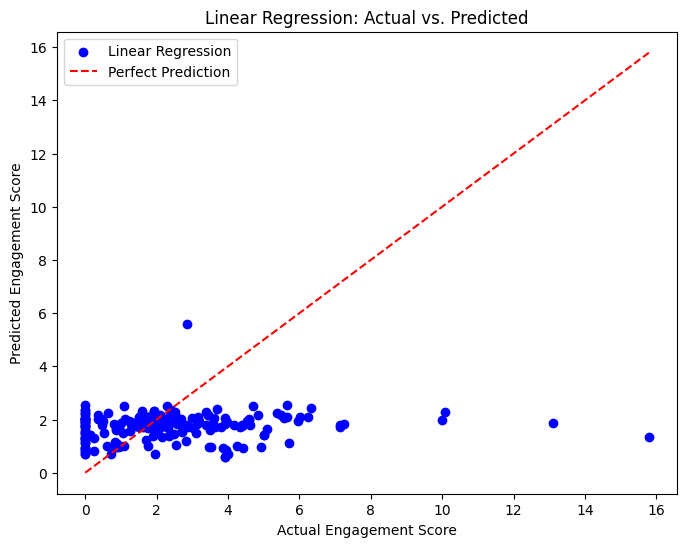

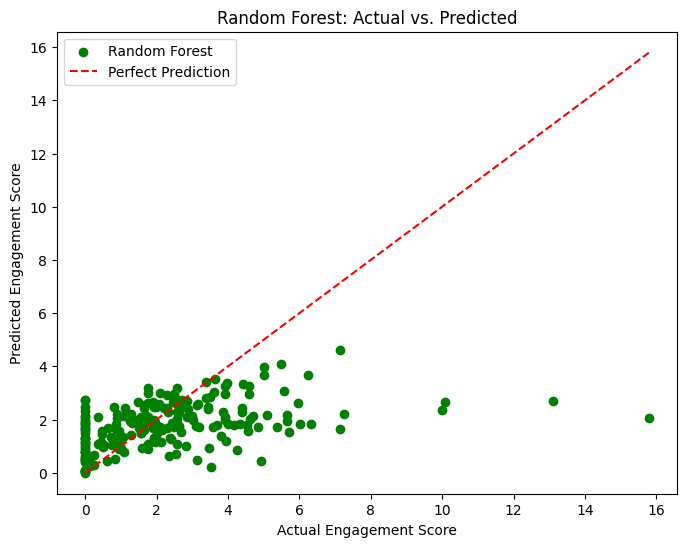

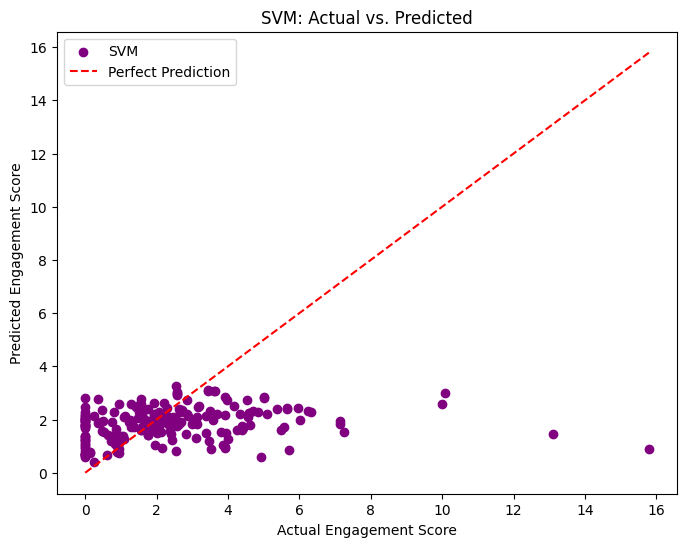

In [ ]:
import matplotlib.pyplot as plt

# Plotting for Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test_log), np.expm1(y_pred_lr_log), color='blue', label='Linear Regression')
plt.plot([min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], [min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Engagement Score')
plt.ylabel('Predicted Engagement Score')
plt.legend()
plt.show()

# Plotting for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test_log), np.expm1(y_pred_rf_log), color='green', label='Random Forest')
plt.plot([min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], [min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], linestyle='--', color='red', label='Perfect Prediction')
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Engagement Score')
plt.ylabel('Predicted Engagement Score')
plt.legend()
plt.show()

# Plotting for SVM
plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test_log), np.expm1(y_pred_svm_log), color='purple', label='SVM')
plt.plot([min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], [min(np.expm1(y_test_log)), max(np.expm1(y_test_log))], linestyle='--', color='red', label='Perfect Prediction')
plt.title('SVM: Actual vs. Predicted')
plt.xlabel('Actual Engagement Score')
plt.ylabel('Predicted Engagement Score')
plt.legend()
plt.show()


## **Model 2**
Topic is a removed feature because Topics were found to be highly correlated with Image Type

In [ ]:
# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Text Sentiment', 'Word Count', 'Number of Hashtags', 'Quality of Image', 'Relevant Image', 'Colorfulness', 'Face Presence']
target = 'Engagement Score'

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

numeric_features = ['Word Count', 'Number of Hashtags', 'Colorfulness']
categorical_features = ['Image Type', 'Text Sentiment', 'Quality of Image', 'Relevant Image', 'Face Presence']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Linear Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])

# Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])

# SVM Regressor pipeline
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', SVR())])

'''pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('scaler', StandardScaler(with_mean=False)),  # Set with_mean=False for sparse matrices
                                ('regressor', SVR())])'''

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression Model
pipeline_lr.fit(X_train, y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Fit the SVM model
pipeline_svm.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
# R-squared for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared: {r2_lr}")


# Calculate mean squared error for Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
# R-squared for Random Forest Regression
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression R-squared: {r2_rf}")

# Calculate mean squared error for SVM Regression
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
# R-squared for SVM Regression
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression R-squared: {r2_svm}")

Image Type: 0.27802303906603065
Text Sentiment: 0.22164304414326672
Word Count: 0.30016000280629423
Number of Hashtags: 0.0038299936883049524
Quality of Image: 0.020709578477020395
Relevant Image: 0.01225780386229861
Colorfulness: 0.0021480733294352602
Face Presence: 0.018482536692534843
Linear Regression Mean Squared Error: 4.8161217186737195
Linear Regression R-squared: 0.021222519165038256
Random Forest Regression Mean Squared Error: 4.589033265535891
Random Forest Regression R-squared: 0.06737356705636144
SVM Regression Mean Squared Error: 5.012545369038627
SVM Regression R-squared: -0.018696539552920166


## **Model 3**
We include the hour of posting as a factor to consider in this verison

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load your dataset (replace 'All_Tweets_Featurized.csv' with your actual file path)
df = pd.read_csv('All_Tweets_Transformed-Final.csv')

# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Topic','Text Sentiment','Word Count', 'Number of Hashtags', 'Quality of Image', 'Relevant Image', 'Face Presence', 'Colorfulness', 'Hour']
target = 'Engagement Score'

# Convert Timestamp to datetime
df_regression['Timestamp'] = pd.to_datetime(df_regression['Timestamp'])

# Hour
df_regression['Hour'] = df_regression['Timestamp'].dt.hour

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

numeric_features = ['Word Count', 'Number of Hashtags', 'Colorfulness', 'Hour']
categorical_features = ['Image Type', 'Topic', 'Text Sentiment', 'Quality of Image', 'Relevant Image', 'Face Presence']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Linear Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])

# Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])

# SVM Regressor pipeline
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', SVR())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression Model
pipeline_lr.fit(X_train, y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Fit the SVM model
pipeline_svm.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
# R-squared for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared: {r2_lr}")


# Calculate mean squared error for Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
# R-squared for Random Forest Regression
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression R-squared: {r2_rf}")

# Calculate mean squared error for SVM Regression
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
# R-squared for SVM Regression
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression R-squared: {r2_svm}")


Image Type: 0.18302549972861928
Topic: 0.14842885467702707
Text Sentiment: 0.18143121762145817
Word Count: 0.19426179427616455
Number of Hashtags: 0.0034808520530160906
Quality of Image: 0.010144014288585659
Relevant Image: 0.005520115008627068
Face Presence: 0.007225013357260447
Colorfulness: 0.02425080768433641
Hour: 0.012737473605584868
Linear Regression Mean Squared Error: 4.747692026050805
Linear Regression R-squared: 0.0351294438800166
Random Forest Regression Mean Squared Error: 3.824866450868775
Random Forest Regression R-squared: 0.22267472294233215
SVM Regression Mean Squared Error: 4.948475305043562
SVM Regression R-squared: -0.0056756195062204196


## **Model 4**
We look at just textual features and their effect here

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Drop rows with NaN values in the target variable
df_regression = df.dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Text Sentiment','Word Count', 'Number of Hashtags']
target = 'Engagement Score'

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

numeric_features = ['Word Count', 'Number of Hashtags']
categorical_features = ['Text Sentiment']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Linear Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])

# Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])

# SVM Regressor pipeline
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', SVR())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression Model
pipeline_lr.fit(X_train, y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Fit the SVM model
pipeline_svm.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
# R-squared for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared: {r2_lr}")


# Calculate mean squared error for Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
# R-squared for Random Forest Regression
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression R-squared: {r2_rf}")

# Calculate mean squared error for SVM Regression
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
# R-squared for SVM Regression
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression R-squared: {r2_svm}")

Text Sentiment: 0.4827023924991778
Word Count: 0.4393318926231953
Number of Hashtags: 0.005043095602568776
Linear Regression Mean Squared Error: 4.7418551766753
Linear Regression R-squared: 0.036315663220283345
Random Forest Regression Mean Squared Error: 5.351741397272202
Random Forest Regression R-squared: -0.08763114158683849
SVM Regression Mean Squared Error: 4.762076602691305
SVM Regression R-squared: 0.032206075138633494


## **Model 5**
We look at just image features here

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Drop rows with NaN values in the target variable
df_regression = pd.read_csv('All_Tweets_Transformed-Final.csv').dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Image Type', 'Quality of Image', 'Relevant Image', 'Face Presence', 'Colorfulness']
target = 'Engagement Score'

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]

numeric_features = ['Colorfulness']
categorical_features = ['Image Type', 'Quality of Image', 'Relevant Image', 'Face Presence']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Linear Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])

# Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])

# SVM Regressor pipeline
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', SVR())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression Model
pipeline_lr.fit(X_train, y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Fit the SVM model
pipeline_svm.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
# R-squared for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared: {r2_lr}")


# Calculate mean squared error for Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
# R-squared for Random Forest Regression
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression R-squared: {r2_rf}")

# Calculate mean squared error for SVM Regression
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
# R-squared for SVM Regression
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression R-squared: {r2_svm}")

Image Type: 0.7984908378495403
Quality of Image: 0.00017513498475815698
Relevant Image: 0.028479993248826756
Face Presence: 0.023713576482882626
Colorfulness: 0.017122592894601135
Linear Regression Mean Squared Error: 4.8806408649995285
Linear Regression R-squared: 0.008110332390035335
Random Forest Regression Mean Squared Error: 6.2700808061662165
Random Forest Regression R-squared: -0.2742646998093412
SVM Regression Mean Squared Error: 5.279069545423594
SVM Regression R-squared: -0.07286208543856887


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Drop rows with NaN values in the target variable
df_regression = pd.read_csv('All_Tweets_Transformed-Final.csv').dropna(subset=['Engagement Score'])

# Define features and target variable
features = ['Colorfulness']
target = 'Engagement Score'

# Separate features and target variable
X = df_regression[features]
y = df_regression[target]


numeric_features = ['Colorfulness']

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Linear Regression pipeline
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])

# Random Forest Regressor pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])

# SVM Regressor pipeline
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', SVR())])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression Model
pipeline_lr.fit(X_train, y_train)

# Fit the Random Forest model
pipeline_rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Fit the SVM model
pipeline_svm.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_svm = pipeline_svm.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")
# R-squared for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared: {r2_lr}")


# Calculate mean squared error for Random Forest Regression
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regression Mean Squared Error: {mse_rf}")
# R-squared for Random Forest Regression
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression R-squared: {r2_rf}")

# Calculate mean squared error for SVM Regression
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f"SVM Regression Mean Squared Error: {mse_svm}")
# R-squared for SVM Regression
r2_svm = r2_score(y_test, y_pred_svm)
print(f"SVM Regression R-squared: {r2_svm}")

Colorfulness: 1.0
Linear Regression Mean Squared Error: 4.930362333273795
Linear Regression R-squared: -0.001994531295657076
Random Forest Regression Mean Squared Error: 6.867679048505145
Random Forest Regression R-squared: -0.3957142262862119
SVM Regression Mean Squared Error: 5.291556082667415
SVM Regression R-squared: -0.07539971679046609
